# Laboratório 1: Exemplo Introdutório 

### Referente ao capítulo 5

Nesse laboratório exploraremos o algoritmo codificado para resolver um problema simples de controle ótimo. 

Estamos interessados em 
$$
\max_u \int_0^1 Ax(t) - Bu^2(t)dt, 
$$
$$
\text{sujeito a   }x'(t) = -\frac{1}{2}x^2(t) + Cu(t), x(0) = x_0 > -2, 
$$
tal que $A \ge 0, B > 0.$ 

## Condições Necessárias 

### Hamiltoniano

$$
H = Ax - Bu^2 + \lambda\left(-\frac{1}{2}x^2 + Cu\right)
$$

### Condição de otimalidade

$$
0 = H_u = -2Bu + C\lambda \implies u^*(t) = \frac{C}{2B}\lambda(t)
$$

### Equação adjunta 

$$
\lambda '(t) = - H_x = -A + x(t)\lambda(t) 
$$

### Condição de transversalidade 

$$
\lambda(1) = 0
$$

Observe que formamos um sistema não linear de equações diferenciais, que tornam a solução analítica muito mais complexa. Por isso, vamos resolver esse problema de forma iterativa. 

### Importanto as bibliotecas

In [1]:
import numpy as np 
from matplotlib import pyplot as plt

### Descrição das equações diferenciais

In [2]:
g = lambda t,x,u: -0.5*x**2 + C*u
dadj = lambda t,x,u,lambda_: - A + x*lambda_
update_u = lambda x,lambda_: 0.5*(C/B)*lambda_

### Passo 2 

Vamos escrever o código do passo 2. Nesse passo, queremos integrar a variável de estado, através do método de Runge-Kutta. Deveríamos obter a variável $u$, nos valores intermediários de Runge-Kutta, em $u_{i+h/2}$ ao invés de $u_i$. Mas não temos aproximação para esse vakir e, portanto aproximamos pela média dos pontos $u_i$ e $u_{i+1}$. 

In [3]:
def forward(g, t, x, u, h): 
    '''A função realiza o processo forward que integra a equação de x' = g
    g: função (t,x,u). 
    x: estado do último passo. Vetor de tamanho N + 1.
    u: controle do último passo. Vetor de tamanho N + 1.
    h: passo a ser dado pelo método de Runge-Kutta. 
    '''
    for i in range(len(t)-1):
        k1 = g(i,x[i],u[i])
        k2 = g(i+h/2,x[i] + 0.5*h*k1, 0.5*(u[i] + u[i+1]))
        k3 = g(i+h/2,x[i] + 0.5*h*k2, 0.5*(u[i] + u[i+1]))
        k4 = g(i+h,x[i] + h*k3, u[i+1])
        x[i+1] = x[i] + (h/6)*(k1 + 2*k2 + 2*k3 + k4)
    return x 

### Passo 3 

Queremos integrar a variável adjunta do fim ao início. Da mesma forma que não obtemos o valor de $x_{i+h/2}$, usamos um aproximação pelo valor médio de $x_i$ e $x_{i+1}$. 

In [4]:
def backward(dadj, t, x, u, lambda_, h): 
    '''A função realiza o processo backward que integra a equação de lambda' = -H_x
    dadj: função (t,x,u) com a derivada de lambda. 
    x: estado calculado. Vetor de tamanho N + 1.
    u: controle do último passo. Vetor de tamanho N + 1.
    lambda_: função adjunta do último passo. Vetor de tamanho N + 1. 
    h: passo a ser dado pelo método de Runge-Kutta. 
    '''
    for i in range(len(t)-1,0,-1):
        k1 = dadj(i,x[i],u[i],lambda_[i])
        k2 = dadj(i-h/2,0.5*(x[i] + x[i-1]), 0.5*(u[i] + u[i-1]),lambda_[i] - 0.5*h*k1)
        k3 = dadj(i-h/2,0.5*(x[i] + x[i-1]), 0.5*(u[i] + u[i-1]),lambda_[i] - 0.5*h*k2)
        k4 = dadj(i-h,x[i-1], u[i-1], lambda_[i] - h*k3)
        lambda_[i-1] = lambda_[i] - (h/6)*(k1 + 2*k2 + 2*k3 + k4)
    return lambda_

### Resolve controle ótimo 

Função que junta todos os passos em uma única função. Observe que o chute inicial de $\vec{u}$ é um vetor aleatório próximo de $0$. Isso para evitar que ele seja $0$. A condição de parada utilizada será a destacada no capítulo 5. 

In [5]:
def optimal_control(A,B,C,x0,h=1e-4,tol=1e-4): 
    '''Resolve o problema de controle ótimo, onde A, B, C e x0 são 
    os parâmetros do problema. 
    A >= 0, B > 0, x0 > -2. 
    h: passo no Runge-Kutta
    tol: tolerância para o erro relativo. 
    '''
    condition = -1 

    N = int(np.round(1/h)) 
    t = np.linspace(0,1,N+1)
    u = np.random.normal(scale=0.01, size=N+1)
    x = np.zeros(N+1)
    lambda_ = np.zeros(N+1)

    x[0] = x0

    while condition < 0: 

        u_old = u.copy()
        x_old = x.copy()
        lambda_old = lambda_.copy()

        x = forward(g,t,x,u,h)
        lambda_ = backward(dadj,t,x,u,lambda_,h)

        # Update u 
        u = 0.5*(update_u(x,lambda_) + u)

        cond1 = tol*sum(abs(u)) - sum(abs(u_old - u))
        cond2 = tol*sum(abs(x)) - sum(abs(x_old - x))
        cond3 = tol*sum(abs(lambda_)) - sum(abs(lambda_old - lambda_))

        condition = min(cond1, cond2, cond3) 

    return t,x,u,lambda_


Note que fazemos uma combinação convexa para atualizar o vetor $u$. Tomamos a média porque ela em geral funciona bem. Diferentes técnicas podem ser necessárias como contraposição a esse método. 

### Plotting Function 

In [6]:
def plotting(t,x,u,lambda_):
    '''Função simples desenvolvida para plot. '''
    variables = {'Estado': x, 'Controle Ótimo': u, 'Função Adjunta': lambda_}

    fig, ax = plt.subplots(3,1,figsize = (15,15))

    for i, key in enumerate(variables):
        ax[i].plot(t,variables[key])
        ax[i].set_title(key, fontsize = 15)
        ax[i].grid(linestyle = '-', linewidth = 1, alpha = 0.5)


## Aplicando as funções ao exemplo 

Vamos fazer algumas exeperimentações. Sinta-se livre para variar os parâmetros. $A$ e $B$ balanceam a importância de maximizar o estado e minimizar o coontrole do quadrado, enquanto $C$ mede o crescimento do estado segundo o controle escolhido. 

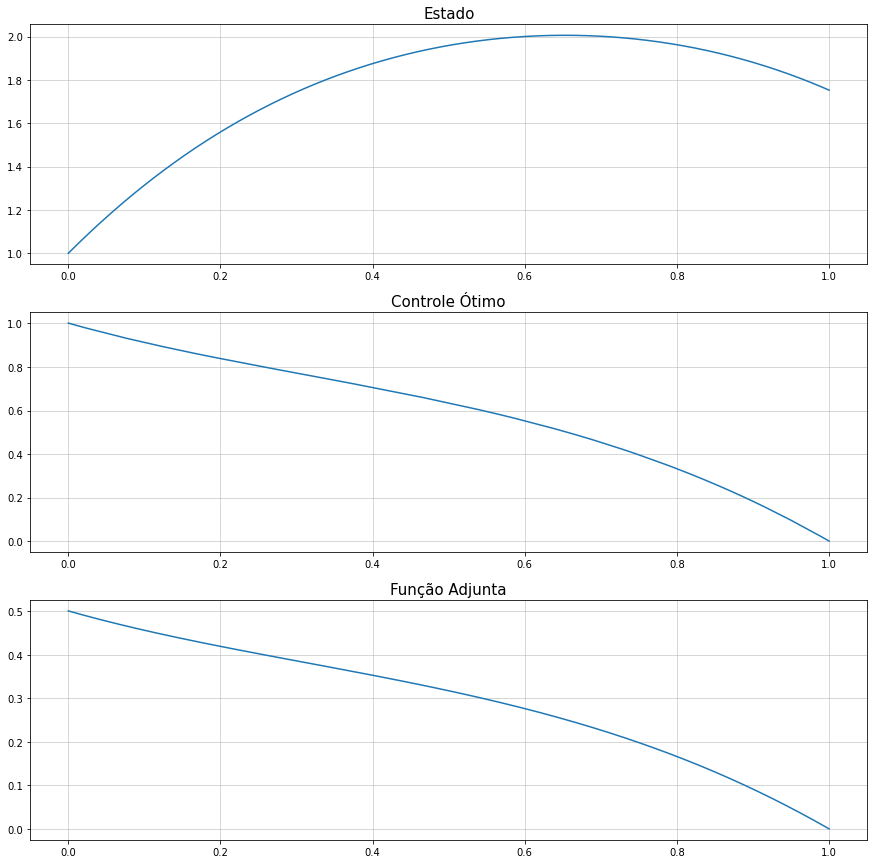

In [7]:
A,B,C,x0 = 1,1,4,1
t,x,u,lambda_ = optimal_control(A,B,C,x0)
plotting(t,x,u,lambda_)

Observe que quando o controle está no início, ele é mais presente, o que puxa o estado para cima. Com a redução do controle, a fim de maximizar o fucional, a sua infuência sobre o estado diminui e, portanto, o estado decaí exponencialmente. Se iniciarmos com o valor inicial, observe que o controle deve ser maior para fazer o efeito desejado sobre o estado. 

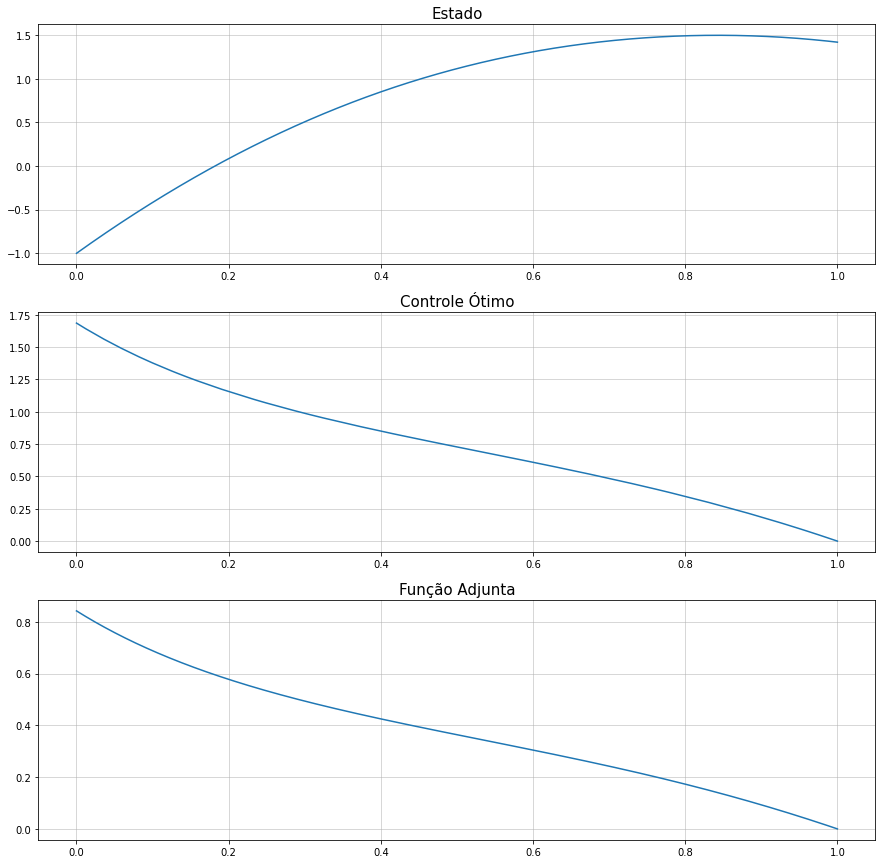

In [8]:
A,B,C,x0 = 1,1,4,-1
t,x,u,lambda_ = optimal_control(A,B,C,x0)
plotting(t,x,u,lambda_)

Agora fazendo $C$ negativo, note que o controle ficou refletido, como era de se esperar. 

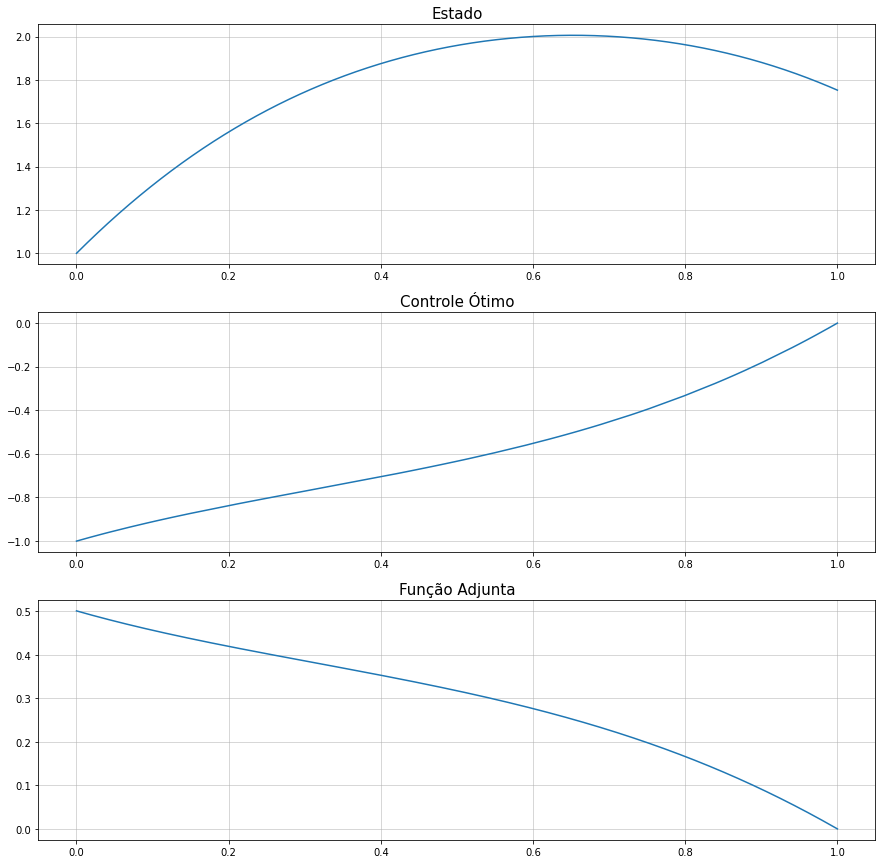

In [9]:
A,B,C,x0 = 1,1,-4,1
t,x,u,lambda_ = optimal_control(A,B,C,x0)
plotting(t,x,u,lambda_)

In [10]:
## Mude os parâmetros aqui para testar. 

#A,B,C,x0 = 1,1,4,-1
#t,x,u,lambda_ = optimal_control(A,B,C,x0)
#plotting(t,x,u,lambda_)

### Este é o final do notebook